In [1]:
%matplotlib inline

import numpy as np
from scipy.fftpack import fft, fftshift, ifft, ifftshift
from scipy.signal import hilbert
from scipy.interpolate import interp1d, griddata
from matplotlib import pyplot as plt
from sknrf.model.dataviewer.dataset import IQFile
from sknrf.utilities.rf import rU2dBU, rW2dBm

# Theory

## IQ Modulation

\begin{align}
\dot{cos(2\pi f_mt + \phi(t))} & = I(t) \cdot cos(2\pi f_mt) - Q(t) \cdot sin(2\pi f_mt)
\end{align}

where:
\begin{align}
f_m \stackrel{\text{def}}{=} \text{is the swept frequency}
\end{align}

## Double Sideband (FUND_DSB)

A double sideband signal can be generated as follows:
\begin{align}
s_\text{dsb}(t) & = I(t) \cdot cos(2\pi f_mt) - Q(t) \cdot sin(2\pi f_mt)
\end{align}

## Single Sideband (FUND_SSB)

The two-tone signal can be reduced to a one-tone signal by ensuring $I(t) = s(t)$  and $Q(t) = \widehat{s}(t)$:
\begin{align}
s_\text{ssb}(t) = s(t)\cdot \cos\left(2\pi f_m t\right) - \widehat s(t)\cdot \sin\left(2\pi f_m t\right)
\end{align}

which implies that realtime frequency sweep can only work when $I(t)$ and $Q(t)$ are related. 

## Discrete Fourier Transform (FUND_DFT)

Finally, you could try to could approximate a frequency sweep using a time-dependent phase shift.
\begin{align}
s_\text{dft}(t) = I(t)\cdot \exp\left(i2\pi f_m t\right) - Q(t)\cdot \exp\left(i2\pi f_m t\right)
\end{align}
This works when sweeping CW sinusoids but is not valid for signals that contain bandwidth


# Conclusion

<table style="width:100%">
  <tr>
    <th>Sweep Name</th>
    <th>FUND_LO</th>
    <th>FUND_DSB</th>
    <th>FUND_SSB</th>
    <th>FUND_DFT</th>
  </tr>
  <tr>
    <td>CW</td>
    <td>Yes</td>
    <td>No</td> 
    <td>Yes (use filter)</td>
    <td>Yes (use filter)</td>
  </tr>
  <tr>
    <td>Pulsed</td>
    <td>Yes</td>
    <td>No</td> 
    <td>Yes</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>Two-Tone</td>
    <td>Yes</td>
    <td>Yes (use filter)</td> 
    <td>No</td>
    <td>No</td>
  </tr>
  <tr>
    <td>IQ</td>
    <td>Yes</td>
    <td>No</td> 
    <td>Yes (if $Q(t) = 0$)</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>Phase Coherent</td>
    <td>No</td>
    <td>Yes</td> 
    <td>No</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>Realtime</td>
    <td>No</td>
    <td>Yes</td> 
    <td>Yes</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>Default Direction</td>
    <td>LOW2HIGH</td> 
    <td>IN2OUT</td> 
    <td>LOW2HIGH</td> 
    <td>LOW2HIGH</td> 
  </tr>
  <tr>
    <td>Odd Samples</td>
    <td>Yes</td>
    <td>Yes</td> 
    <td>Yes</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>Even Samples</td>
    <td>Yes</td>
    <td>No</td> 
    <td>No</td>
    <td>No</td>
  </tr>
  <tr>
    <td>Max Span (w/ Filter)</td>
    <td>Any</td>
    <td>$\frac{-1}{2t_{step}} \leq fund \leq \frac{+1}{2t_{step}}$</td>
    <td>$\frac{-1}{2t_{step}} < fund < \frac{+1}{2t_{step}}$</td>
    <td>$\frac{-1}{2t_{step}} < fund < \frac{+1}{2t_{step}}$</td>
  </tr>
  <tr>
    <td>Max Span (w/0 Filter)</td>
    <td>Any</td>
    <td>$\frac{-0.1}{2t_{step}} \leq fund \leq \frac{+0.1}{2t_{step}}$</td>
    <td>$\frac{-0.1}{2t_{step}} < fund < \frac{+0.1}{2t_{step}}$</td>
    <td>$\frac{-0.1}{2t_{step}} < fund < \frac{+0.1}{2t_{step}}$</td>
  </tr>
  <tr>
    <td>Max Points</td>
    <td>Any</td>
    <td>$ceil(t_{points}/2)$</td>
    <td>$t_{points}-2$</td>
    <td>$t_{points}-2$</td>
  </tr>
  <tr>
    <td>Applications</td>
    <td><ul><li>Unlocked LO</li><li>LO Only</li><li>Phase Incoherent</li></ul></td>
    <td><ul><li>Two-Tone</li><li>Realtime</li></ul><li>Phase Coherent</li></td>
    <td><ul><li>Narrowband</li><li>Scalar Modulated</li><li>Phase Incoherent</li></ul></td>
    <td><ul><li>Narrowband</li><li>Vector Modulated</li><li>Phase Coherent</li></ul></td>
  </tr>
</table>


## Functions

In [2]:
def sinc(t, iq):    
    t_step = t[0, 1] - t[0, 0]
    freq_m = np.linspace(-1/(2*t_step), 1/(2*t_step), t.size) + np.zeros(iq.shape)
    x = t_step*np.pi*freq_m
    x[np.abs(x) < 1e-100] = 1e-100 
    return np.abs(np.sin(x)/(x))
    
    
def sample_filter(t, iq, filter_, points, all_=False):
    if t.size % 2: # odd
        IQ = fftshift(fft(iq, axis=-1), axes=-1)/t.shape[-1]
        IQ = IQ*filter_
        IQ = np.sum(IQ, axis=-2, keepdims=True) if all_ else IQ
        iq_ = ifft(ifftshift(IQ, axes=-1), axis=-1)*t.shape[-1]
    else: # t.size % 2 == 0: # even
        raise NotImplementedError("Time points and Fund points must be odd.")
#         IQ = fft(iq, axis=-1)/t.shape[-1]
#         IQ = IQ*filter_
#         IQ = np.sum(IQ, axis=-2, keepdims=True) if all_ else IQ
#         iq_ = ifft(IQ, axis=-1)*t.shape[-1]
    return iq_


def fund_interp(t, span, points, grid):
    t_step = t[0, 1] - t[0, 0]
    fund = np.linspace(-span/2, span/2, points)
    return griddata(grid, grid, fund, method="nearest")
    
        
def fund_dsb(t, iq, span, points, filter_=False, all_=False):
    t_step = t[0, 1] - t[0, 0]
    grid = np.linspace(-1/(2*t_step), 1/(2*t_step), t.size)
    fund = fund_interp(t, span, points, grid).reshape(-1, 1)
    fund = fund[0:np.ceil(points/2), :]
    iq_ = iq.real*np.cos(2*np.pi*fund*t) - iq.imag*np.sin(2*np.pi*fund*t)
    
    if filter_:
        sinc_t = sinc(t, iq_)
        sinc_t[1:-1, :] /= 2
        return sample_filter(t, iq_, 1/sinc_t, points, all_=all_)
    else:
        return iq_


def fund_ssb(t, iq, span, points, filter_=False, all_=False):
    t_step = t[0, 1] - t[0, 0]
    grid = np.linspace(-1/(2*t_step), 1/(2*t_step), t.size)[t.size/(points-1):-t.size/(points-1)]
    fund = fund_interp(t, span, points, grid).reshape(-1, 1)
    sa = hilbert(iq, axis=-1)
    iq_ = sa.real*np.exp(1j*2*np.pi*fund*t)
    
    if filter_:
        sinc_t = sinc(t, iq_)
        return sample_filter(t, iq_, 1/sinc_t, points, all_=all_)
    else:
        return iq_
    
    
def fund_dft(t, iq, span, points, filter_=False, all_=False):
    t_step = t[0, 1] - t[0, 0]
    grid = np.linspace(-1/(2*t_step), 1/(2*t_step), t.size)[t.size/(points-1):-t.size/(points-1)]
    fund = fund_interp(t, span, points, grid).reshape(-1, 1)
    iq_ = iq*np.exp(1j*2*np.pi*fund*t)
    
    if filter_:
        sinc_t = sinc(t, iq_)
        return sample_filter(t, iq_, 1/sinc_t, points, all_=all_)
    else:
        return iq_

# Narrow-Band Signals

## CW Double Sideband (DSB)

In [3]:
t_step = 1.0e-6
t_stop = 100.0e-6
points = 11
span = 1/t_step
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_dsb(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), iq.transpose())
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## CW Single Sideband (SSB)

In [ ]:
t_step = 1.0e-6
t_stop = 100.0e-6
span = 1/t_step
points = 11
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_ssb(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

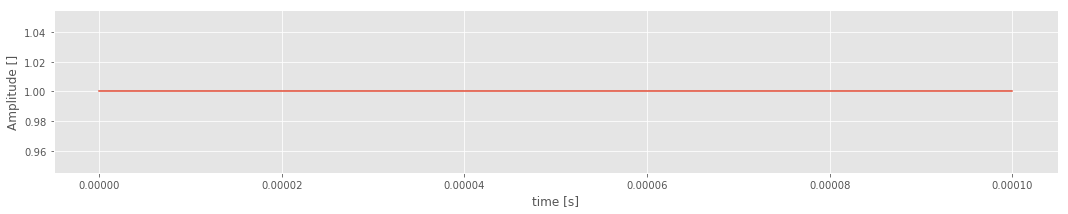

In [4]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), iq.transpose())
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [5]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

((1, 101), (1, 101))

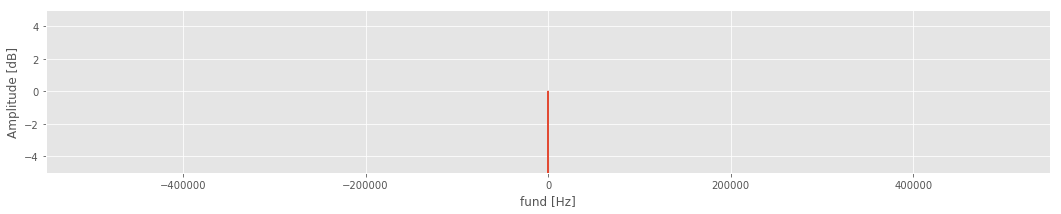

In [6]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## CW DFT

In [7]:
t_step = 1.0e-6
t_stop = 100.0e-6
span = 1/t_step
points = 11
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_dft(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

TypeError: slice indices must be integers or None or have an __index__ method

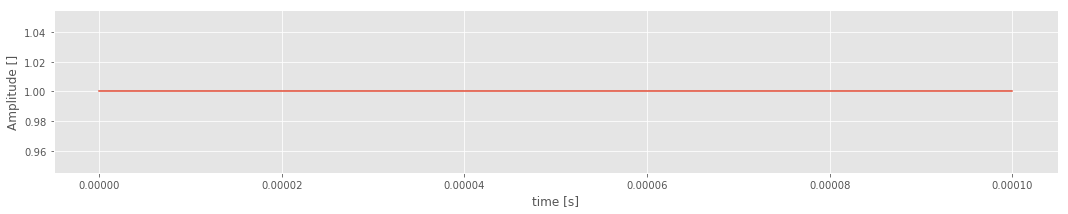

In [8]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), iq.transpose())
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [9]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

((1, 101), (1, 101))

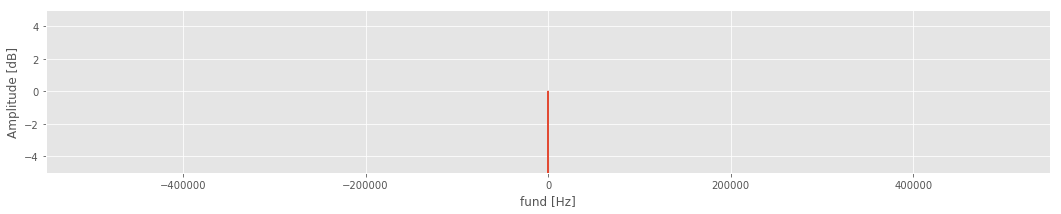

In [10]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

# Wideband Signals

In [11]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
fm = np.linspace(-1/(2*t_step), 1/(2*t_step), 11).reshape(-1, 1)
iq_file = IQFile(r"C:\Users\db888079\AppData\Roaming\sknrf\signals\LTE_FDD_UL\16QAM\Basic\5M_25RB\IQ_LTE_16QAM_5M25RB.h5", "r")
iq = iq_file.iq.real.reshape(1, -1)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

OSError: ``C:\Users\db888079\AppData\Roaming\sknrf\signals\LTE_FDD_UL\16QAM\Basic\5M_25RB\IQ_LTE_16QAM_5M25RB.h5`` does not exist

ValueError: x and y must have same first dimension, but have shapes (32769, 1) and (101, 1)

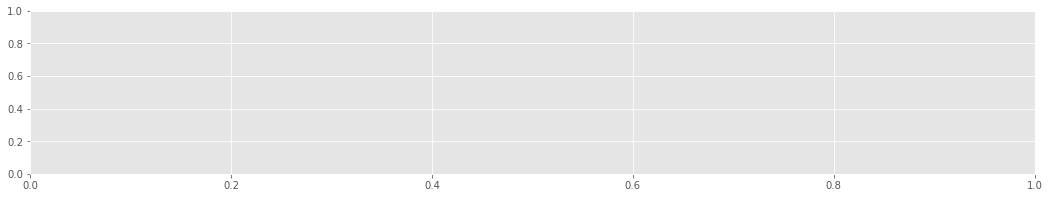

In [12]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), np.abs(iq.transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [13]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

((1, 32769), (1, 101))

ValueError: x and y must have same first dimension, but have shapes (32769, 1) and (101, 1)

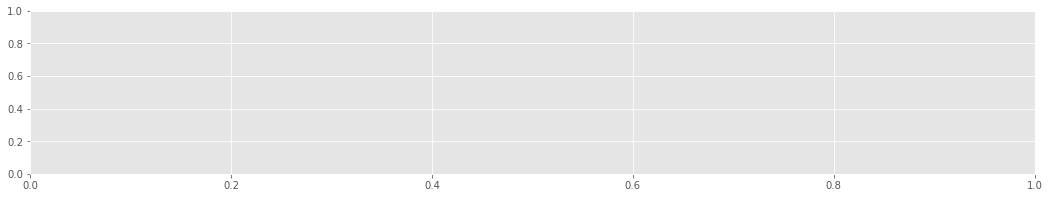

In [14]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:, :].transpose(), rU2dBU(IQ[:, :].transpose()))
ax = plt.gca()
ax.set_ylim((-50, -40))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG CW DSB

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 1/t_step
points = 100
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_dsb(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t[:,:].transpose(), rU2dBU(iq[:,:].transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG CW SSB

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 1/t_step
points = 100
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_ssb(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t[:,:].transpose(), rU2dBU(iq[:,:].transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG CW DFT

As shown above, the SSB of a modulated cuts off half of the spectrum. 

Empirical analysis shows that we can still shift a modulated I/Q signal without using the SSB technique. The SSB technique was only needed for the CW case.

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 1/t_step
points = 100
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq = np.ones(t.size, dtype=float).reshape(1, -1)
iq = fund_dft(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), np.abs(iq.transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-5, 5))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG MOD DSB

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 0.1/t_step
points = 11
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq_file = IQFile(r"C:\Users\db888079\AppData\Roaming\sknrf\signals\LTE_FDD_UL\16QAM\Basic\5M_25RB\IQ_LTE_16QAM_5M25RB.h5", "r")
iq = iq_file.iq.real.reshape(1, -1)
iq = fund_dsb(t, iq, span, points, filter_=True, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), np.abs(iq.transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-50, -40))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG MOD SSB

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 1/t_step
points = 11
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq_file = IQFile(r"C:\Users\db888079\AppData\Roaming\sknrf\signals\LTE_FDD_UL\16QAM\Basic\5M_25RB\IQ_LTE_16QAM_5M25RB.h5", "r")
iq = iq_file.iq.real.reshape(1, -1)
iq = fund_ssb(t, iq, span, points, filter_=False, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), np.abs(iq.transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:,:].transpose(), rU2dBU(IQ[:,:].transpose()))
ax = plt.gca()
ax.set_ylim((-50, -40))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")

## AWG MOD DFT

In [ ]:
t_step = 0.2604166666666667e-6
t_stop = 8533.333333333334e-6
span = 1/t_step
points = 11
t = np.arange(0.0, t_stop + t_step/10, t_step).reshape(1, -1)
f = np.arange(-1/(2*t_step), 1/(2*t_step) + 1, 1/t_stop).reshape(1, -1)
iq_file = IQFile(r"C:\Users\db888079\AppData\Roaming\sknrf\signals\LTE_FDD_UL\16QAM\Basic\5M_25RB\IQ_LTE_16QAM_5M25RB.h5", "r")
iq = iq_file.iq.real.reshape(1, -1)
iq = fund_dft(t, iq, span, points, filter_=False, all_=False)
t = t + np.zeros(iq.shape)
f = f + np.zeros(iq.shape)
t.shape, iq.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(t.transpose(), np.abs(iq.transpose()))
ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("Amplitude []")

In [ ]:
IQ = fftshift(fft(iq, axis=-1), axes=-1)/f.shape[-1]
f.shape, IQ.shape

In [ ]:
plt.figure(1, figsize=(18,3))
plts = plt.plot(f[:, :].transpose(), rU2dBU(IQ[:, :].transpose()))
ax = plt.gca()
ax.set_ylim((-50, -40))
ax.set_xlabel("fund [Hz]")
ax.set_ylabel("Amplitude [dB]")